In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import cmocean
import os

import sys; sys.path.append('../src/training-on-CM2.6')

from helpers.plot_helpers import default_rcParams

%load_ext autoreload
%autoreload 2
import warnings
warnings.filterwarnings("ignore")

# Computing crossections of 1000-days average interfaces

In [2]:
from functools import cache
@cache
def interface(exp='R4-long/bare', lon=0, layer=None):
    base_path = '/scratch/pp2681/mom6/Neverworld2/simulations'
    if exp=='R32':
        ds = xr.open_mfdataset(f'{base_path}/R32/longmean*.nc', decode_times=False)
    else:
        try:
            ds = xr.open_dataset(f'{base_path}/{exp}/output/longmean_00029050.nc', decode_times=False)
        except:
            print('Experiment does not exist')
                                                                                                                                                
    e = ds.e
    
    if lon is not None:
        # lon=0,15,30,45
        if lon == 0:
            e = e.isel(xh=0)
        else:
            e = e.interp(xh=lon)
    
    if layer is not None:
        # layer = 0 is ssh
        e = e.isel(zi=layer)

    return e.mean('time').compute()

In [3]:
def interfaces(exp='R4-long/bare', lon=0, layer=None, lat_max=None):
    '''
    Simple wrapper returning hires and lores interfaces
    '''
    hires = interface('R32', lon=lon, layer=layer).sel(yh=slice(None,lat_max))
    lores = interface(exp, lon=lon, layer=layer).sel(yh=slice(None,lat_max))

    if lon is None:
        factor = len(hires.xh) // len(lores.xh)
        return hires.coarsen({'xh': factor, 'yh': factor}).mean().interp(xh=lores.xh, yh=lores.yh), lores
    elif layer is None:
        return hires.interp(yh=lores.yh), lores
    else:
        print('Not implemented')

def rmse(hires, lores):
    error = (lores - hires)
    if 'zi' in error.dims:
        error = error.isel(zi=slice(0,15))
    RMSE = np.sqrt((error**2).mean()) # RMSE in metres
    return round(float(RMSE),3)

In [9]:
# Test values
print(rmse(*interfaces(lon=0)))
print(rmse(*interfaces(lon=15)))
print(rmse(*interfaces(lon=30)))
print(rmse(*interfaces(lon=45)))
print(rmse(*interfaces(lon=None,layer=0)))
print(rmse(*interfaces(lon=None,layer=None)))

52.14
42.119
40.3
34.63
0.101
36.84


# Interface plotting function

In [4]:
def plot_interfaces(hires, lores):
    for zi in range(15):
        lores.isel(zi=zi).plot(ls='--', color='blue', lw=2)
        hires.isel(zi=zi).plot(ls='-', color='k', lw=2, alpha=0.5)
    hires.isel(zi=-1).plot(color='k') # show bathymetry 
    
    RMSE = rmse(hires,lores)
    plt.text(0.7,0.1,'RMSE=\n'+"{:.1f}".format(RMSE)+'$\,\mathrm{m}$', fontsize=15, transform = plt.gca().transAxes)
    plt.xlabel('Latitude')
    plt.yticks(np.arange(-4000,1000,1000), np.arange(4000,-1000,-1000))
    plt.ylabel('Depth [m]')
    plt.title('')

# Figure S3

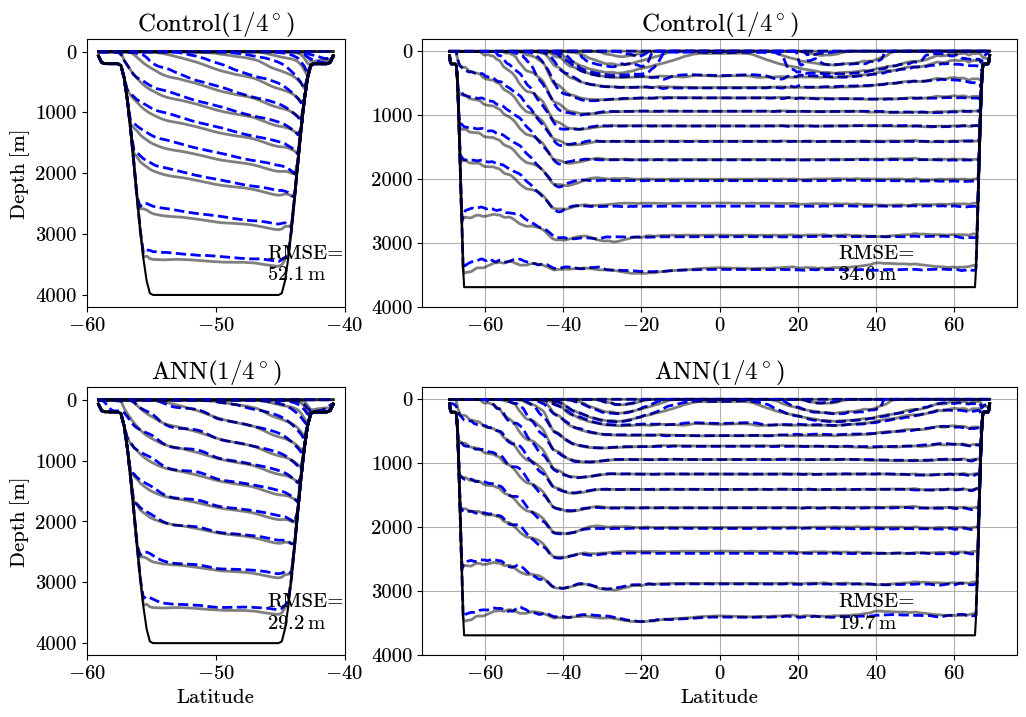

In [14]:
from matplotlib import gridspec
default_rcParams({'font.size': 15})
fig = plt.figure(figsize=(12,8))
gs = gridspec.GridSpec(2, 3, figure=fig, wspace=0.3, hspace=0.3)

kw = {'lon': 0, 'lat_max': None}

plt.sca(fig.add_subplot(gs[0, 0]))
plot_interfaces(*interfaces('R4-long/bare', **kw))
plt.title('Control($1/4^\circ$)')
plt.xlabel('')

plt.sca(fig.add_subplot(gs[1, 0]))
plot_interfaces(*interfaces('R4-ANN/May22-Coriolis-upd', **kw))
plt.title('ANN($1/4^\circ$)')

kw = {'lon': 45, 'lat_max': None}
plt.sca(fig.add_subplot(gs[0, 1:]))
plot_interfaces(*interfaces('R4-long/bare', **kw))
plt.title('Control($1/4^\circ$)')
plt.ylabel('')
plt.xlabel('')
plt.grid()

plt.sca(fig.add_subplot(gs[1, 1:]))
plot_interfaces(*interfaces('R4-ANN/May22-Coriolis-upd', **kw))
plt.title('ANN($1/4^\circ$)')
plt.ylabel('')
plt.grid()


plt.tight_layout()
#plt.savefig('/home/pp2681/MOM6-examples/src/MOM6/experiments/ANN-Results/notebooks-paper/figures/interfaces_lon_0_lon_45_NW2-upd.pdf')

# Table S2

In [16]:
# 1/4 degree resolution
for exp, label in zip(['R4-long/bare', 'R4-long/Yankovsky23-0.3', 'R4-long/Reynolds-newest-code', 'R4-ANN/May22-Coriolis-upd'], ['Control', 'Yankovsky24', 'ZB20-Reynolds', 'ANN']):
    str = label
    for lon in [0,15,30,45]:
        error = rmse(*interfaces(exp=exp,lon=lon))
        str = str + ' %.1f ' % error
    print(str)

Control 52.1  42.1  40.3  34.6 
Yankovsky24 27.8  23.0  20.7  21.3 
ZB20-Reynolds 26.9  21.0  18.4  18.5 
ANN 29.2  20.0  16.7  19.7 


In [5]:
# 1/3 degree resolution
for exp, label in zip(['R3-long/bare', 'R3-long/Yankovsky24', 'R3-long/ZB20-Reynolds', 'R3-ANN/May22-Coriolis-upd'], ['Control', 'Yankovsky24', 'ZB20-Reynolds', 'ANN']):
    str = label
    for lon in [0,15,30,45]:
        error = rmse(*interfaces(exp=exp,lon=lon))
        str = str + ' %.1f ' % error
    print(str)

Control 51.3  46.8  49.1  36.8 
Yankovsky24 33.5  31.6  29.9  27.4 
ZB20-Reynolds 32.7  25.4  26.1  21.6 
ANN 35.0  24.3  30.9  28.6 


In [6]:
# 1/6 degree resolution
for exp, label in zip(['R6/bare', 'R6/Yankovsky23', 'R6/ZB20-Reynolds', 'R6/ANN'], 
                      ['Control', 'Yankovsky24', 'ZB20-Reynolds', 'ANN']):
    str = label
    for lon in [0,15,30,45]:
        error = rmse(*interfaces(exp=exp,lon=lon))
        str = str + ' %.1f ' % error
    print(str)

Control 42.7  30.7  31.8  26.7 
Yankovsky24 26.2  22.3  16.1  16.8 
ZB20-Reynolds 27.7  24.5  18.9  18.4 
ANN 23.5  18.8  13.8  14.6 


# Table S3

In [33]:
# Compute ACC transport from instantaneous snapshots
@cache
def ACC(exp='R4-long/bare'):
    base_path = '/scratch/pp2681/mom6/Neverworld2/simulations'
    if exp=='R32':
        ds = xr.open_mfdataset(f'{base_path}/R32/snapshots*.nc', decode_times=False).isel(time=slice(None,None,6))
        static = xr.open_dataset(f'{base_path}/R32/static.nc', decode_times=False)
    else:
        for file in ['snapshots_00029010.nc', 'snapshots_00029020.nc', 'snapshots_00029025.nc', 'snapshots_00029030.nc']:
            try:
                ds = xr.open_dataset(f'{base_path}/{exp}/output/{file}', decode_times=False).sel(time=slice(29200,None))
                static = xr.open_dataset(f'/scratch/pp2681/mom6/Neverworld2/simulations/{exp}/output/static.nc', decode_times=False)
            except:
                pass
    
    u = ds.u.sel(xq=0).load()
    h = ds.h.isel(xh=[0,-1]).load()
    h_interp = (h.isel(xh=0) + h.isel(xh=-1)) * 0.5
    dyCu = static.dyCu.sel(xq=0).load()

    transport = u*h_interp*dyCu
    
    return transport.sum(['yh', 'zl']) * 1e-6

In [38]:
# 1/4 degree resolution
for exp, label in zip(['R32', 'R4-long/bare', 'R4-long/Yankovsky23-0.3', 'R4-long/Reynolds-newest-code', 'R4-ANN/May22-Coriolis-upd'], ['1/32-degree', 'Control', 'Yankovsky24', 'ZB20-Reynolds', 'ANN']):
    str = label
    transport = ACC(exp).mean()
    str = str + ' %.1f ' % transport
    print(str)

1/32-degree 235.3 
Control 245.1 
Yankovsky24 229.9 
ZB20-Reynolds 225.4 
ANN 236.9 


In [39]:
# 1/3 resolution
for exp, label in zip(['R3-long/bare', 'R3-ANN/May22-Coriolis-upd'], ['Control', 'ANN']):
    str = label
    transport = ACC(exp).mean()
    str = str + ' %.1f ' % transport
    print(str)

Control 242.7 
ANN 241.6 


In [40]:
# 1/6 resolution
for exp, label in zip(['R6/bare', 'R6/Yankovsky23', 'R6/ZB20-Reynolds', 'R6/ZB20-Smooth', 'R6/ANN'], 
                      ['Control', 'Yankovsky24', 'ZB20-Reynolds', 'ZB20-Smooth', 'ANN']):

    str = label
    transport = ACC(exp).mean()
    str = str + ' %.1f ' % transport
    print(str)

Control 243.3 
Yankovsky24 230.4 
ZB20-Reynolds 219.5 
ZB20-Smooth 227.3 
ANN 228.8 


# Time series (not in the paper)

In [76]:
default_rcParams({'figure.subplot.wspace': 0.05, 'figure.subplot.hspace': 0.15, 'font.size': 12})
def plot_timeseries(exps=['R4-long/bare'], labels=None, tmax=30000):
    plt.figure(figsize=(10,6))
    if labels is None:
        labels=exps
    for exp, label in zip(exps, labels):
        try:
            ds = xr.open_dataset(f'/scratch/pp2681/mom6/Neverworld2/simulations/{exp}/output/ocean.stats.nc', decode_times=False)
        except:
            ds = xr.open_dataset(f'/scratch/pp2681/mom6/Neverworld2/simulations/{exp}/ocean.stats.nc', decode_times=False)
        ticks = [0,int(tmax/3),int(tmax*2/3),int(tmax)]
        plt.subplot(2,1,1)
        (ds.KE.sum('Layer').groupby('Time').min()).plot()
        plt.xlabel('Days')
        plt.xticks(ticks,ticks)
        plt.axhline(y=2.45e+18, color='k')
        plt.xlim([0,tmax])
        plt.grid()

        plt.subplot(2,1,2)
        (ds.APE.sum('Interface').groupby('Time').min()).plot(label=label)
        plt.xlabel('Days')
        plt.xticks(ticks,ticks)
        plt.axhline(y=0.958e+20, color='k')
        plt.xlim([0,tmax])
        plt.grid()
    plt.tight_layout()
    plt.legend(bbox_to_anchor=(1,1))

Text(0.5, 0.98, 'Time series at 1/6-degree resolution')

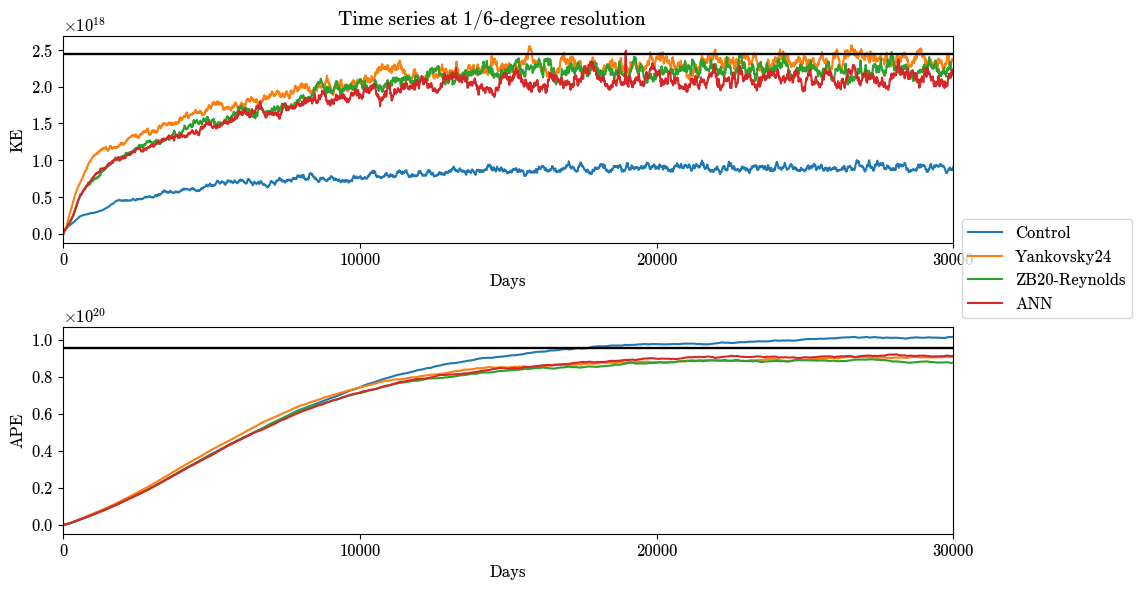

In [77]:
plot_timeseries(['R6/bare', 'R6/Yankovsky23', 'R6/ZB20-Reynolds', 'R6/ANN'], 
                      ['Control', 'Yankovsky24', 'ZB20-Reynolds',  'ANN'])
plt.suptitle('Time series at 1/6-degree resolution')

Text(0.5, 0.98, 'Time series at 1/4-degree resolution')

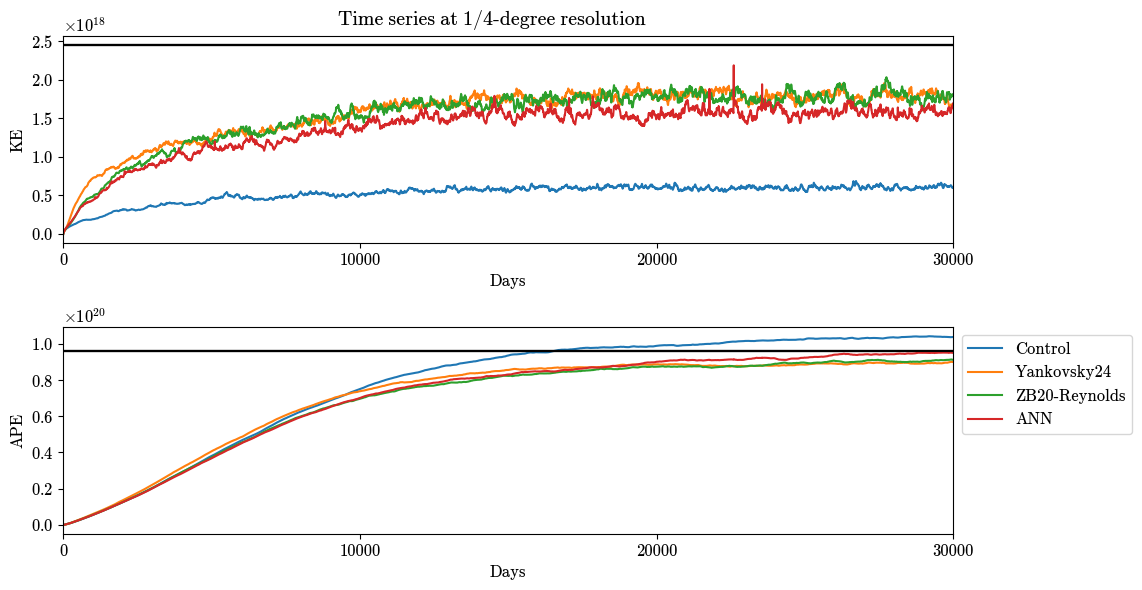

In [78]:
plot_timeseries(['R4-long/bare', 'R4-long/Yankovsky23-0.3', 'R4-long/Reynolds-newest-code', 'R4-ANN/May22-Coriolis-upd'], ['Control', 'Yankovsky24', 'ZB20-Reynolds', 'ANN'])
plt.suptitle('Time series at 1/4-degree resolution')